In [95]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [96]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/roberta-finetuned"

sys.path.insert(0, ABSOLUTE_PATH)

# Fine-tuning RoBERTa model

In [97]:
!pip install tensorboardX

In [98]:
import os

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import classification_report

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

## Loading the model and tokenizer

In [99]:
MODEL_NAME = "roberta-base"
NUM_LABELS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-5
EARLY_STOPPING = 3

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Loading the preprocessed data

In [101]:
# Import splits of the dataset (train, val, test)
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"))
)

train_df.rename(columns={'account.type': 'label'}, inplace=True)
val_df.rename(columns={'account.type': 'label'}, inplace=True)
test_df.rename(columns={'account.type': 'label'}, inplace=True)

# Extra processing for pytorch dataset
X_train = train_df['text'].values
y_train = (train_df['label'] == 'bot').astype(int).values

X_val = val_df['text'].values
y_val = (val_df['label'] == 'bot').astype(int).values

X_test = test_df['text'].values
y_test = (test_df['label'] == 'bot').astype(int).values

In [102]:
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

## Training the model

In [105]:
training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    # metric_for_best_model=metric_name,
)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
    callbacks=[early_stopping],
)

<ipython-input-105-d19c4a9ca5c5>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [106]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.300100,0.312262,0.890530
2,0.292800,0.414750,0.868375
3,0.211800,0.578032,0.881842
4,0.132500,0.488862,0.897480


TrainOutput(global_step=10356, training_loss=0.2463298214131131, metrics={'train_runtime': 1885.7182, 'train_samples_per_second': 109.836, 'train_steps_per_second': 13.73, 'total_flos': 2.179822471446528e+16, 'train_loss': 0.2463298214131131, 'epoch': 4.0})

In [107]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.28883785009384155,
 'eval_accuracy': 0.8932759761810303,
 'eval_runtime': 9.5993,
 'eval_samples_per_second': 266.686,
 'eval_steps_per_second': 33.336,
 'epoch': 4.0}

In [108]:
test_results_df = pd.DataFrame.from_dict(test_results, orient="index", columns=["value"])
test_results_df.index.name = "metric"
test_results_df.reset_index(inplace=True)
test_results_df

,metric,value
0,eval_loss,0.288838
1,eval_accuracy,0.893276
2,eval_runtime,9.599300
3,eval_samples_per_second,266.686000
4,eval_steps_per_second,33.336000
5,epoch,4.000000


In [109]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [110]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1278
           1       0.88      0.92      0.90      1280

    accuracy                           0.89      2558
   macro avg       0.89      0.89      0.89      2558
weighted avg       0.89      0.89      0.89      2558



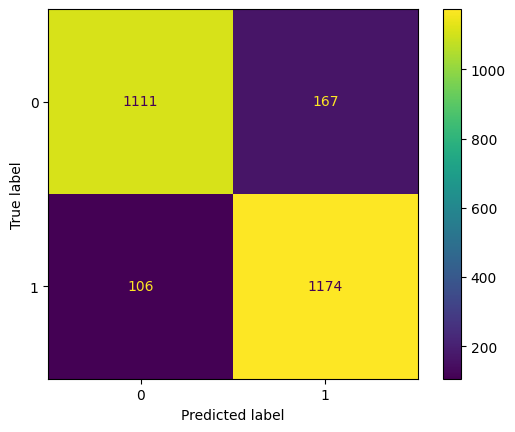

In [111]:
plot_confusion_matrix(y_test, predicted_labels)